In [1]:
import os, glob, sys
import matplotlib.pyplot as plt
import numpy as np
import h5py
import tensorflow as tf
%matplotlib inline
import skimage
from skimage.io import imread, imshow, imsave
from tensorflow.python.keras.models import *
from tensorflow.python.keras.layers import *
from tensorflow.python.keras.optimizers import *
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler
# from keras import backend as keras
import time
from eval import *
from ShowColors import *
from ImportUtil import *
%env CITYSCAPES_DATASET = /home/rvygon/data/

%load_ext autoreload
%autoreload 2

env: CITYSCAPES_DATASET=/home/rvygon/data/


In [2]:
#run this cell once
#%run  cityscapesscripts/preparation/createTrainIdLabelImgs
def upd_print(str):
            sys.stdout.write('\r')       
            sys.stdout.write(str)
            sys.stdout.flush()

In [5]:
img_shape = (256, 512, 3)
batch_size = 1
total_size = 700
val_size = 50
scale_rate = 4
verbose = 0
start_index = 0
import functools

In [6]:
x_train_data, y_train_data = importBatch(total_size, start_index, verbose,'train', scale_rate)
from tensorflow.python.keras.utils import to_categorical
y_train_data = to_categorical(y_train_data)
x_train_data = x_train_data.astype('uint8')
y_train_data = y_train_data.astype('uint8')

# TODO REWRITE IMPORT BATCH FOR VALIDATION DATA
x_val_data, y_val_data = importBatch(val_size, start_index, verbose, 'val', scale_rate)
y_val_data = to_categorical(y_val_data)
x_val_data = x_val_data.astype('uint8')
y_val_data = y_val_data.astype('uint8')
#x_val, y_val,files = importBatch(10,0,0,'val',scale = 4)
# from keras.utils import to_categorical

#y_val = to_categorical(y_val)

In [7]:
# import numpy as np
# import matplotlib.pyplot as plt
# # def IoU_metric(y_true, y_preds):
    
# def preprocess_pic(X, y):    
#     y=to_categorical(y)
#     return X, y

# def keras_generator(batch_size,scale):
#     while True:
#         batch_nums = np.random.randint(low=1000, high=2000, size=batch_size)
#         batch_input = []
#         batch_output = []
        
#         for index in batch_nums:
#             input_labels, input_images = getData(1, index,type='train')
#             input_image = input_images[0]
#             input_label = input_labels[0]           
            
#             X_img = imread(input_image)
#             if (scale != 0):
#                 X_new = np.zeros((int(X_img.shape[0] / scale), int(X_img.shape[1] / scale),3))
#                 k = 0
#                 for x in X_img[::scale]:
#                     X_new[k]=x[::scale]
#                     k+=1
#                 X_img = X_new
#             y_img = imread(input_label)
#             if (scale != 0):
#                 y_new = np.zeros((int(y_img.shape[0] / scale), int(y_img.shape[1] / scale)))
#                 k = 0
#                 for y in y_img[::scale]:
#                     y_new[k] = y[::scale]
#                     k += 1
#                 y_img = y_new
            
#             X_img, y_img = preprocess_pic(X_img, y_img)
            
#             batch_input.append(X_img)
#             batch_output.append(y_img)
            
#         batch_x = np.array(batch_input)
#         batch_y = np.array(batch_output)        
#         yield batch_x, batch_y
        

In [6]:
# #visualize
# num = 10
# # chosed = np.random.choice(len(x_train_data), num)
# chosed = range(10)
# plt.figure(figsize=(20, 25))
# for i in range(0, num * 3, 3):
#     img_num = chosed[i // 3]
#     x = x_train_data[img_num]
#     y = y_train_data[img_num]
#     sess = tf.Session()
#     with sess.as_default():
#         plt.subplot(num, 3, i + 1)
#         plt.imshow(x)
#         plt.title("Original")
#         img, label = tr_preprocessing_fn(x, y)
#         x = img.eval()
#         y = label.eval()
#         plt.subplot(num, 3, i + 2)
#         plt.imshow(x)
#         plt.title("Augmented")
    
#         y = np.argmax(y, axis=2)
#         plt.subplot(num, 3, i + 3)
#         plt.imshow(y)
#         plt.title("Masked")

# plt.suptitle("Images and Masks")
# plt.show()

In [7]:
#UNET https://github.com/zhixuhao/unet/blob/master/model.py
def unet(pretrained_weights=None, input_size=img_shape):
    inputs = Input(input_size)
  
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)    
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))#drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(20, 1, activation = 'sigmoid')(conv9)

    model = Model([inputs], [conv10])

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [8]:
def shifted_image(image, label, width_shift_range, height_shift_range):
    """horisontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
        image = tf.contrib.image.translate(image, [width_shift_range, height_shift_range])
        label = tf.contrib.image.translate(label, [width_shift_range, height_shift_range])
    return image, label
            

In [9]:
def flip_img(horizontal_flip, image, label):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        image, label = tf.cond(tf.less(flip_prob, 0.5),
                                   lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
                                   lambda: (image, label))
    return image, label

In [10]:
# def upscale_img(img, scale, dims):
#     if dims:
#         new_img = tf.zeros((img.shape[0] * scale, img.shape[1] * scale, 3))
#         for i in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 new_img[i * scale:(i + 1) * scale, j * scale:(j + 1) * scale, :] = img[i, j, :]
#     else:
#         new_img = np.zeros((img.shape[0] * scale, img.shape[1] * scale))
#         for i in range(img.shape[0]):
#             for j in range(img.shape[1]):
#                 new_img[i * scale:(i + 1) * scale, j * scale:(j + 1) * scale] = img[i, j]
#     return new_img

In [11]:
def crop_img(crop_rate, image, label):
    if crop_rate is not None:
        image = tf.image.resize_images(tf.image.central_crop(image, crop_rate), (img_shape[0], img_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        label = tf.image.resize_images(tf.image.central_crop(label, crop_rate), (img_shape[0], img_shape[1]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, label

In [12]:
def _augment(image,
             label,
             hue_delta=0,
             horisontal_flip=False,
             width_shift_range=0,
             height_shift_range=0,
             crop_rate=None):
    if hue_delta:
        image = tf.image.random_hue(image, hue_delta)
    image, label = flip_img(horisontal_flip, image, label)
    image, label = shifted_image(image, label, width_shift_range, height_shift_range)
    image, label = crop_img(crop_rate, image, label)
    return image, label

In [13]:
def to_tensor(image, label):
    return image, label

In [14]:
def get_dataset(images, labels,
                preproc_fn=functools.partial(_augment),
                threads=5,
                batch_size=batch_size,
                shuffle=True):
    num_x = len(images)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
#     dataset = dataset.map(to_tensor, num_parallel_calls=threads)
#     dataset = dataset.map(preproc_fn)
    if shuffle:
        dataset = dataset.shuffle(num_x)
    dataset = dataset.repeat().batch(batch_size)
    return dataset

In [15]:
tr_cfg = {
    'hue_delta': 0.2,
    'horisontal_flip': True,
    'crop_rate' : 0.5
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [16]:
val_cfg = {
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

In [17]:
train_ds = get_dataset(x_train_data, 
                       y_train_data,
                       preproc_fn=tr_preprocessing_fn,
                       batch_size=batch_size)
val_ds = get_dataset(x_val_data,
                      y_val_data,
                      preproc_fn=val_preprocessing_fn,
                      batch_size=batch_size)


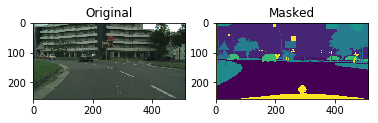

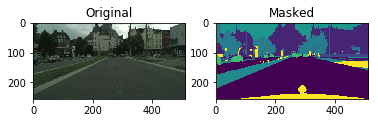

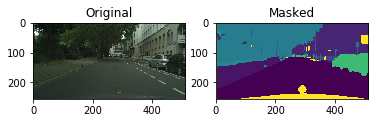

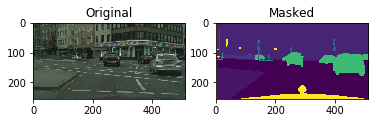

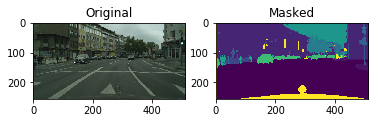

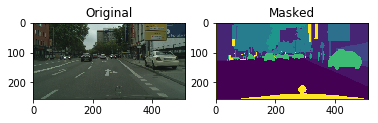

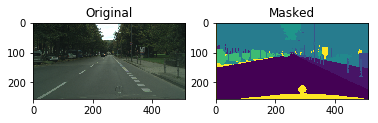

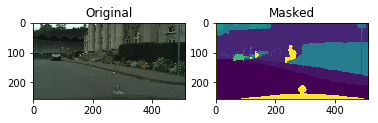

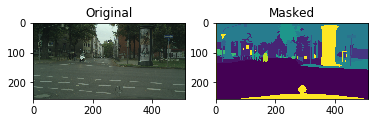

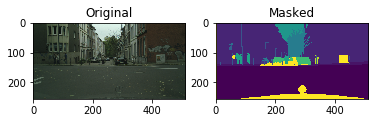

In [18]:
# TEST #
temp_ds = get_dataset(x_train_data,
                     y_train_data,
                     preproc_fn=tr_preprocessing_fn,
                     batch_size=10,
                     shuffle=False)
data_aug_iter = temp_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()
for i in range(10):
    with tf.Session() as sess:
        batch_of_imgs, batch_of_labels = sess.run(next_element)
        img = batch_of_imgs[i]
        label = batch_of_labels[i]
        label = np.argmax(label, axis=2)
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title("Original")
        plt.subplot(1, 2, 2)
        plt.imshow(label)
        plt.title("Masked")
        plt.show()

In [4]:
# from tensorflow.python.keras.callbacks import CSVLogger
# csv_logger = CSVLogger('log.csv', append=True, separator=';')

In [15]:
# # model = unet()
# model = load_model('unet_tensorflow.hdf5')
# model_checkpoint = ModelCheckpoint('unet_tensorflow.hdf5', monitor='loss', verbose=1, save_best_only=True)
# history = model.fit(train_ds, steps_per_epoch=1500,epochs=100,callbacks=[model_checkpoint, csv_logger])#, validation_data=(x_val,y_val),validation_steps=20)

In [23]:
# VGG19 ENCODER
from tensorflow.python.keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.applications.vgg19 import VGG19
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing import image

vgg_model = VGG19(weights='imagenet', input_shape=(256, 512, 3), include_top=False)

In [24]:
vgg_out = vgg_model.output
vgg_out

<tf.Tensor 'block5_pool/MaxPool:0' shape=(?, 8, 16, 512) dtype=float32>

In [25]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 128, 128)      0         
__________

In [26]:
conv1 = vgg_model.get_layer('block2_conv1').output #shape 128 256 64
conv2 = vgg_model.get_layer('block2_pool').output #shape 64 128 64
conv3 = vgg_model.get_layer('block4_conv4').output #shape 32 64 128
conv4 = vgg_model.get_layer('block5_conv4').output #shape 16 32 256
conv5 = vgg_model.get_layer('block5_pool').output #shape 8 16 512

In [27]:
def vgg_unet(pretrained_weights = None,input_size = (256,512,3)):
    conc_1 = Concatenate(axis=3)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv_conc_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_1)
    conv_conc_1 = BatchNormalization()(conv_conc_1)
    conv_conc_1 = LeakyReLU()(conv_conc_1)
    conv_conc_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_1)
    conv_conc_1 = BatchNormalization()(conv_conc_1)
    conv_conc_1 = LeakyReLU()(conv_conc_1)
    
    conc_2 = Concatenate(axis=3)([UpSampling2D(size=(2, 2))(conv4), conv3])
    conv_conc_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_2)
    conv_conc_2 = BatchNormalization()(conv_conc_2)
    conv_conc_2 = LeakyReLU()(conv_conc_2)
    conv_conc_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_2)
    conv_conc_2 = BatchNormalization()(conv_conc_2)
    conv_conc_2 = LeakyReLU()(conv_conc_2)
    
    conc_3 = Concatenate(axis=3)([UpSampling2D(size=(2, 2))(conv3), conv2])
    conv_conc_3 = Conv2D(64, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_3)
    conv_conc_3 = BatchNormalization()(conv_conc_3)
    conv_conc_3 = LeakyReLU()(conv_conc_3)
    conv_conc_3 = Conv2D(64, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_3)
    conv_conc_3 = BatchNormalization()(conv_conc_3)
    conv_conc_3 = LeakyReLU()(conv_conc_3)
    
    conc_4 = Concatenate(axis=3)([UpSampling2D(size=(2, 2))(conv2), conv1])
    conv_conc_4 = Conv2D(32, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_4)
    conv_conc_4 = BatchNormalization()(conv_conc_4)
    conv_conc_4 = LeakyReLU()(conv_conc_4)
    conv_conc_4 = Conv2D(32, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_4)
    conv_conc_4 = BatchNormalization()(conv_conc_4)
    conv_conc_4 = LeakyReLU()(conv_conc_4)
    
    conc_5 = UpSampling2D(size=(2, 2))(conv_conc_4)
    conv_conc_5 = Conv2D(16, (3, 3), padding='same', kernel_initializer = 'he_normal')(conc_5)
    conv_conc_5 = BatchNormalization()(conv_conc_5)
    conv_conc_5 = LeakyReLU()(conv_conc_5)
    conv_conc_5 = Conv2D(16, (3, 3), padding='same', kernel_initializer = 'he_normal')(conv_conc_5)
    conv_conc_5 = BatchNormalization()(conv_conc_5)
    conv_conc_5 = LeakyReLU()(conv_conc_5)
    
    last = Conv2D(20, 1, activation = 'sigmoid')(conv_conc_5)
    
    model = Model(vgg_model.input, last)
    
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [28]:
from tensorflow.python.keras.callbacks import CSVLogger
vgg_csv_logger = CSVLogger('vgg_log.csv', append=True, separator=';')

In [38]:
with tf.device('/device:GPU:3'):
#     vgg_unet_model = vgg_unet()
    vgg_unet_model = load_model('vgg_unet_tensorflow.hdf5')
    vgg_model_checkpoint = ModelCheckpoint('vgg_unet_tensorflow.hdf5', monitor='loss', verbose=1, save_best_only=True)
    vgg_history = vgg_unet_model.fit(train_ds, steps_per_epoch=500,epochs=100,
                                     callbacks=[vgg_model_checkpoint, vgg_csv_logger],
                                     validation_data=val_ds,
                                     validation_steps=25)

Epoch 1/100
500/500 [==============================] - 90s 180ms/step - loss: 0.5467 - acc: 0.8380 - val_loss: 0.9872 - val_acc: 0.6889: - ETA:

Epoch 00001: loss improved from inf to 0.54672, saving model to vgg_unet_tensorflow.hdf5
Epoch 2/100
500/500 [==============================] - 53s 107ms/step - loss: 0.5415 - acc: 0.8373 - val_loss: 1.2159 - val_acc: 0.6613

Epoch 00002: loss improved from 0.54672 to 0.54147, saving model to vgg_unet_tensorflow.hdf5
Epoch 3/100
500/500 [==============================] - 53s 107ms/step - loss: 0.5451 - acc: 0.8385 - val_loss: 1.0406 - val_acc: 0.7023A: 1s - loss: 0.5450 

Epoch 00003: loss did not improve from 0.54147
Epoch 4/100
500/500 [==============================] - 51s 102ms/step - loss: 0.5348 - acc: 0.8407 - val_loss: 0.9877 - val_acc: 0.6977

Epoch 00004: loss improved from 0.54147 to 0.53477, saving model to vgg_unet_tensorflow.hdf5
Epoch 5/100
500/500 [==============================] - 54s 107ms/step - loss: 0.5319 - acc: 0.8412 - 

KeyboardInterrupt: 

In [34]:
from eval import *

In [39]:
SCALE = 4
def eval_model(model):          
        x_pred = model.predict(x_val_data,verbose=1)        
        new_x = np.argmax(x_pred, axis=3)
        new_x = new_x.astype(np.uint8)        
        
        new_y = np.argmax(y_val_data, axis=3)
        new_y = new_y.astype(np.uint8)
        score = eval_preds(new_x, new_y)  
        return score

model = load_model('vgg_unet_tensorflow.hdf5')
print(eval_model(model))

50/50 [==============================] - 21s 414ms/step
processed 49 images
road : 0.6822326157561579
sidewalk : 0.16553538950624058
building : 0.4817740621740672
wall : 0.0
fence : 0.00011809987424711824
pole : 0.15418192388555949
traffic light : 0.002688578368890724
traffic sign : 0.11605064594049921
vegetation : 0.7227402047720969
terrain : 0.033845581947976766
sky : 0.6657499335634722
person : 0.06637739592698538
rider : 0.0
car : 0.2694234573035849
truck : 0.0
bus : 0.0
train : 0.0
motorcycle : 0.0
bicycle : 0.007745701710734675
0.1957626591942861


1/1 [==============================] - 20s 20s/step


/opt/conda/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


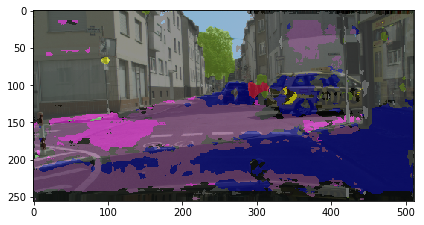

In [40]:
model = load_model('vgg_unet_tensorflow.hdf5')
x_pred = model.predict(x_val_data[0:1],verbose=1)  
pred_image=np.argmax(x_pred[0],axis=2).astype(int)
colorImage(x_val_data[0],pred_image, 'classes.txt', 'colors.txt', 'vgg19_unet_after_training.png')